In [2]:
import numpy as np
import networkx as nx
from rpy2.robjects import r
import osmnx as ox
import networkx as nx
import json
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from python_tsp.heuristics import solve_tsp_simulated_annealing, solve_tsp_lin_kernighan

ox.settings.log_console = True
ox.__version__

r('library(TSP)')
r.concorde_path("/home/woonam/concorde/TSP")

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


found: concorde concorde.c concorde.o 


'/home/woonam/concorde/TSP'


In [3]:
%matplotlib inline

In [4]:
def merge_nodes(graph, node1, node2):
    edges = ox.graph_to_gdfs(graph, edges=True, nodes=False)
    # node1과 node2의 모든 이웃을 가져옵니다.
    neighbors1 = list(graph.neighbors(node1))
    neighbors2 = list(graph.neighbors(node2))
    
    # node1을 기준으로 이웃을 병합합니다.
    for neighbor in neighbors2:
        if neighbor not in neighbors1:
            graph.add_edge(node1, neighbor, length=edges['length'][min(neighbor, node2)][max(neighbor, node2)][0]+edges['length'][min(node1, node2)][max(node1, node2)][0])

    # node2를 그래프에서 제거합니다.
    graph.remove_node(node2)
    
    return graph

In [5]:
def merge_nodes_with_neighbor(graph, node1, node2):
    edges = ox.graph_to_gdfs(graph, edges=True, nodes=False)
    
    # node1과 node2의 모든 이웃을 가져옵니다.
    neighbors1 = list(graph.neighbors(node1))
    neighbors2 = list(graph.neighbors(node2))
    
    for neighbor1 in neighbors1:
        for neighbor2 in neighbors2:
            if not graph.has_edge(neighbor1, neighbor2):
                graph.add_edge(neighbor1, neighbor2, length=edges['length'][min(node1, neighbor1)][max(node1, neighbor1)][0]+edges['length'][min(node2, neighbor2)][max(node2, neighbor2)][0]+edges['length'][min(node1, node2)][max(node1, node2)][0])

    # node2를 그래프에서 제거합니다.
    graph.remove_node(node1)
    graph.remove_node(node2)
    
    return graph

In [6]:
def merge_nodes_by_edge_count(graph, edge_count):
    graph_simple = nx.Graph(graph)
    # 엣지 개수가 주어진 값인 노드들을 찾습니다.
    nodes_to_merge = [node for node, degree in graph.degree() if degree == edge_count and graph.has_node(node)]
    
    # 각 노드를 이웃한 노드에 병합합니다.
    for node in nodes_to_merge:
        if not graph.has_node(node):
            continue
        neighbors = list(graph.neighbors(node))
        neighbor = neighbors[0]
        if neighbor != node:
            graph = merge_nodes(graph, neighbor, node)
    
    return graph

In [7]:
def remove_degree_one_nodes_multigraph_1(graph):
    # Degree가 1인 노드 확인
    degree_one_nodes = [node for node, degree in graph.degree() if degree == 1]
    
    # Degree가 1인 노드의 이웃 엣지 제거
    for node in degree_one_nodes:
        edges = list(graph.edges(node))
        graph.remove_edges_from(edges)
    
    # Degree가 1인 노드 제거
    graph.remove_nodes_from(degree_one_nodes)
    
    return graph

In [8]:
def num_degree_k_nodes(graph, k):
    graph_dir = ox.convert.to_digraph(graph, weight='length')
    graph_undir = graph_dir.to_undirected()
    
    loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
    graph_undir.remove_edges_from(loops)
    
    degree_k_nodes = [node for node, degree in graph_undir.degree() if degree == k]
    
    return len(degree_k_nodes)

"""def num_degree_k_nodes(graph, k):
    graph_undir = ox.convert.to_undirected(graph)
    
    loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
    graph_undir.remove_edges_from(loops)
    
    degree_k_nodes = [node for node, degree in graph_undir.degree() if degree == k]
    
    return len(degree_k_nodes)"""

'def num_degree_k_nodes(graph, k):\n    graph_undir = ox.convert.to_undirected(graph)\n    \n    loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]\n    graph_undir.remove_edges_from(loops)\n    \n    degree_k_nodes = [node for node, degree in graph_undir.degree() if degree == k]\n    \n    return len(degree_k_nodes)'

In [9]:
def remove_degree_one_nodes_multigraph(graph):
    graph_dir = ox.convert.to_digraph(graph, weight='length')
    graph_undir = graph_dir.to_undirected()
    
    loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
    graph_undir.remove_edges_from(loops)
    
    degree_one_nodes = [node for node, degree in graph_undir.degree() if degree == 1]
    while len(degree_one_nodes) != 0:
        # Degree가 1인 노드의 이웃 엣지 제거
        for node in degree_one_nodes:
            edges = list(graph.edges(node))
            graph.remove_edges_from(edges)
        
        # Degree가 1인 노드 제거
        graph.remove_nodes_from(degree_one_nodes)
        
        graph_dir = ox.convert.to_digraph(graph, weight='length')
        graph_undir = graph_dir.to_undirected()
        
        loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
        graph_undir.remove_edges_from(loops)
        
        degree_one_nodes = [node for node, degree in graph_undir.degree() if degree == 1]
    
    return graph

In [10]:
def remove_degree_two_nodes_multigraph(graph):
    graph_dir = ox.convert.to_digraph(graph, weight='length')
    graph_undir = graph_dir.to_undirected()
    
    loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
    graph_undir.remove_edges_from(loops)
    
    degree_two_nodes = [node for node, degree in graph_undir.degree() if degree == 2]
    
    while len(degree_two_nodes) != 0:
        for node in degree_two_nodes:
            if not graph.has_node(node):
                continue
            neighbors = list(graph.neighbors(node))
            neighbor = random.choice(neighbors)
            if neighbor != node:
                graph = merge_nodes(graph, neighbor, node)
    
        graph_dir = ox.convert.to_digraph(graph, weight='length')
        graph_undir = graph_dir.to_undirected()
        
        loops = [(n, n) for n in graph_undir.nodes if graph_undir.has_edge(n, n)]
        graph_undir.remove_edges_from(loops)
        
        degree_two_nodes = [node for node, degree in graph_undir.degree() if degree == 2]
        print(degree_two_nodes)
                
    return graph

In [11]:
def concorde_TSP_solver(mat):
    """
    Solve traveling salesman problem with concorde solver using R
    :param mat: input matrix
    :return: optimized tour length
    """
    r.assign('mat', mat)
    # change list data to matrix data
    r('Matrix_x <- matrix(unlist(mat), ncol = length(mat), byrow = TRUE)')
    # use concorde TSP solver
    r('tsp <- TSP(Matrix_x)')
    r('tour <- solve_TSP(tsp, "concorde")')
    # get tour length from solved data
    result = r('tour_length(tour)')

    return result

In [12]:
def graph_to_distance_matrix(G):
    size = len(G.nodes())
    dist_matrix = np.zeros((size, size))
    for i, u in enumerate(G.nodes()):
        for j, v in enumerate(G.nodes()):
            if i != j:
                #dist_matrix[i][j] = round(G[u][v]['weight']*100) if G.has_edge(u, v) else 15000
                dist_matrix[i][j] = int(G[u][v]['weight']) if G.has_edge(u, v) else 50000
    return dist_matrix

In [13]:
def remove_bridge_edge(graph):
    # Convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=False), ox.graph_to_gdfs(graph, edges=True, nodes=False)
    
    edges_array = edges.axes[0][0:len(edges)].to_numpy()
    
    G = nx.Graph()
    
    # 각 간선의 출발 노드와 도착 노드를 읽어와서 degree 계산
    for edge in edges_array:
        u, v, _ = edge
        G.add_edge(u, v)
    
    bridge_edge = nx.minimum_edge_cut(G)
    while len(bridge_edge) == 1:
        graph = merge_nodes_with_neighbor(graph, list(bridge_edge)[0][0], list(bridge_edge)[0][1])
        # Convert the graph to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=False), ox.graph_to_gdfs(graph, edges=True, nodes=False)
        
        edges_array = edges.axes[0][0:len(edges)].to_numpy()
        
        G = nx.Graph()
        
        # 각 간선의 출발 노드와 도착 노드를 읽어와서 degree 계산
        for edge in edges_array:
            u, v, _ = edge
            G.add_edge(u, v)
        bridge_edge = nx.minimum_edge_cut(G)
        
    return graph

In [14]:
def osmnx_TSP_optimizer(location_point, file_name):
    graph = ox.graph_from_point(location_point, dist=700, dist_type='network')
    #graph = ox.graph_from_place(location_point, custom_filter='["power"~"line"]')
    print('graph generated')
    graph = graph.to_undirected()
    while num_degree_k_nodes(graph, 1) != 0 or num_degree_k_nodes(graph, 2) != 0:
        graph = remove_degree_one_nodes_multigraph(graph)
        graph = remove_degree_two_nodes_multigraph(graph)
    graph = remove_bridge_edge(graph)
    print('graph converted')
    
    # Convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=False), ox.graph_to_gdfs(graph, edges=True, nodes=False)
    
    lengths = edges['length'].to_numpy()
    edges_array = edges.axes[0][0:len(edges)].to_numpy()
    
    G_final = nx.Graph()
    
    # 각 간선의 출발 노드와 도착 노드를 읽어와서 degree 계산
    for edge, w in zip(edges_array, lengths):
        u, v, _ = edge
        G_final.add_edge(u, v, weight=round(w))
    
    # 그래프 노드의 인덱스를 1부터 순차적으로 변경
    node_mapping = {node: i for i, node in enumerate(G_final.nodes)}
    
    # 새로운 노드 인덱스 적용
    G_final = nx.relabel_nodes(G_final, node_mapping)
    
    distance_matrix = graph_to_distance_matrix(G_final)
    
    con_result = concorde_TSP_solver(distance_matrix.tolist())[0]
    lk_result = []
    for iter in range(100):
        lk_opt, lk_distance = solve_tsp_lin_kernighan(distance_matrix)
        lk_result.append(lk_distance)
    if con_result < 50000:
        with open(f'TSP_dataset_{file_name}.json', 'r') as file:
            dataset = json.load(file)
        dataset['con_result'].append(con_result)
        dataset['lk_result'].append(lk_result)
        dataset['distance_matrix'].append(distance_matrix.tolist())
        dataset['location_point'].append(location_point)
        
        with open(f'TSP_dataset_{file_name}.json', 'w') as file:
            json.dump(dataset, file)

In [27]:
dataset = {'con_result': [], 'lk_result': [], 'distance_matrix': [], 'location_point': []}
    
with open(f'TSP_dataset_osmnx_seoul.json', 'w') as file:
    json.dump(dataset, file)

In [ ]:
"""서울 도심 (37.6097,127.0119)에서 (37.5549,127.0798)까지 직사각형 범위를 100등분"""
for lat in range(10):
    lattitude = 37.6097 - lat * 0.0008
    for lon in range(10):
        longitude = 127.0119 + lon * 0.0035
        print('location is ', (lattitude, longitude))
        osmnx_TSP_optimizer((lattitude, longitude), 'osmnx_seoul')
        clear_output()

In [30]:
"""부산 도심 (35.1983,129.0701)에서 (35.1734,129.1082)까지 직사각형 범위를 100등분"""
for lat in range(10):
    lattitude = 37.5696 - lat * 0.0061
    for lon in range(10):
        longitude = 129.0701 + lon * 0.0042
        print('location is ', (lattitude, longitude))
        osmnx_TSP_optimizer((lattitude, longitude), 'osmnx_busan')
        clear_output()

location is  (37.5696, 129.0701)
graph generated
[]


NetworkXError: The node 4683665914 is not in the graph.

In [ ]:
"""도쿄 도심 (35.7690,139.6534)에서 (35.6675,139.8579)까지 직사각형 범위를 100등분"""
for lat in range(10):
    lattitude = 35.7690 - lat * 0.011
    for lon in range(10):
        longitude = 139.6534 + lon * 0.0227
        print('location is ', (lattitude, longitude))
        osmnx_TSP_optimizer((lattitude, longitude), 'osmnx_tokyo')
        clear_output()

In [15]:
"""뉴욕 도심 (40.7484,-73.9195)에서 (40.6740,-73.7576)까지 직사각형 범위를 100등분"""
for lat in range(10):
    lattitude = 40.7484 - lat * 0.008
    for lon in range(10):
        longitude = -73.9195 + lon * 0.018
        print('location is ', (lattitude, longitude))
        osmnx_TSP_optimizer((lattitude, longitude), 'osmnx_newyork')
        clear_output()

location is  (40.724399999999996, -73.9195)
graph generated
[3628898331, 5482425948, 5482425968, 7644827951, 7712008361, 8670712316]
[5482425965, 5482425966]
[5482425966]
[5482425963, 5482425964]
[]
[5482425973, 5482634971, 7712008355]
[42859995, 42916218, 5482634971, 7712008355]
[]


NetworkXError: The node 7712008355 is not in the graph.

In [16]:
"""보스턴 도심 (42.3301,-71.1464)에서 (42.2768,-71.0737)까지 직사각형 범위를 100등분"""
for lat in range(10):
    lattitude = 42.3301 - lat * 0.006
    for lon in range(10):
        longitude = -71.1464 + lon * 0.008
        print('location is ', (lattitude, longitude))
        osmnx_TSP_optimizer((lattitude, longitude), 'osmnx_boston')
        clear_output()

location is  (42.3181, -71.1304)
graph generated
[61349062, 61349069, 61378641, 61413317, 63546120, 63575034, 7226792899]
[61349064, 61413317, 61550340]
[]
[]


ValueError: graph contains no nodes

In [ ]:
osmnx_TSP_optimizer((42.3582,-71.0809), 'osmnx_boston')

In [6]:
def average_degree(graph):
    """
    Calculates the average degree
    :param graph: input graph
    :return: average degree of graph
    """
    if not isinstance(graph, nx.Graph):
        mat = np.array(graph)
        mat[mat == 50000] = 0
        graph = nx.Graph(mat)

    degree = sum(dict(graph.degree()).values()) / len(graph)

    return degree

[0.02642738 1.         0.02129623 0.03244625 0.04021422 0.02565924
 0.0083646  0.01444628 0.01230737 0.0229149  0.01801932 0.00994565
 0.02724581 0.03727741 0.01860962]


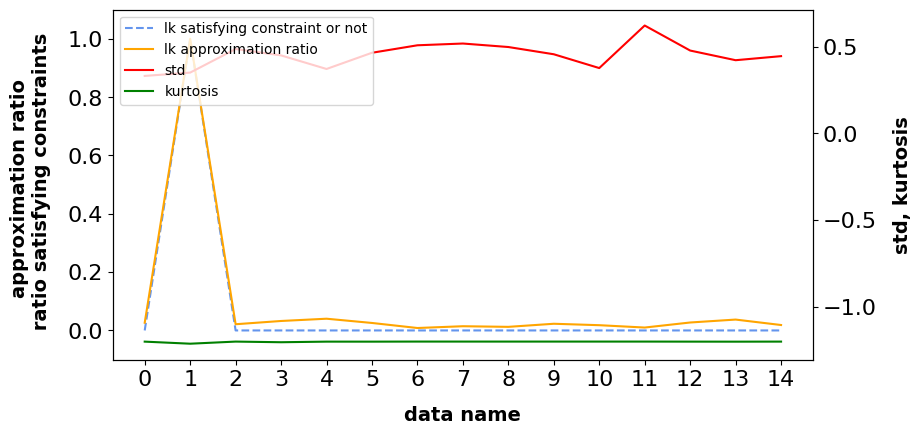

In [3]:
from scipy.stats import kurtosis

file_name = f'TSP_dataset_osmnx_seoul.json'
with open(file_name, 'r') as file:
    dataset = json.load(file)
distance_matrix = dataset['distance_matrix'][:100]
lk_result = dataset['lk_result'][:100]
con_result = dataset['con_result'][:100]
std = []
kurt = []
for i in range(len(distance_matrix)):
    mat = np.array(distance_matrix[i])
    mat[mat == 50000] = 0
    G = nx.Graph(mat)
    degrees = list(dict(G.degree()).values())
    std.append(np.std(degrees))
    kurt.append(kurtosis(G))

lk_result_a = np.array(lk_result)
con_aa = np.array(con_result)
lk_success = (con_aa / lk_result_a)
print(lk_success)

rewiring_probs = np.arange(len(con_result))
aa = len(rewiring_probs)
# Plotting results
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set x-axis
plt.xlabel('data name', fontsize=14, labelpad=12, fontweight='bold')
#plt.xscale('log')  # Setting x-axis to log scale
lk_inter_counts = np.ones(aa)
lk_inter_counts[np.array(lk_result) > 50000] = 0

# Set y-axis1 data
ax1.set_ylabel('approximation ratio \n ratio satisfying constraints', fontsize=14, labelpad=12, fontweight='bold')
ax1.plot(rewiring_probs, lk_inter_counts, label='lk satisfying constraint or not', linestyle='--',
         color='cornflowerblue')
ax1.plot(rewiring_probs, lk_success, label='lk approximation ratio', color='orange')
ax1.set_ylim(-0.1, 1.1)
ax1.tick_params(labelsize=16)
ax1.set_xticks(range(aa), labels=rewiring_probs)

# Set y-axis2 data
ax2 = ax1.twinx()
ax2.set_ylabel('std, kurtosis', fontsize=14, labelpad=12, fontweight='bold')
ax2.plot(rewiring_probs, std, label='std', color='Red')
ax2.plot(rewiring_probs, kurt, label='kurtosis', color='green')
#ax2.set_ylim()
ax2.tick_params(labelsize=16)
ax2.set_xticks(range(aa), labels=rewiring_probs)

plt.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.9, wspace=0.3)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

[0. 1. 0.]


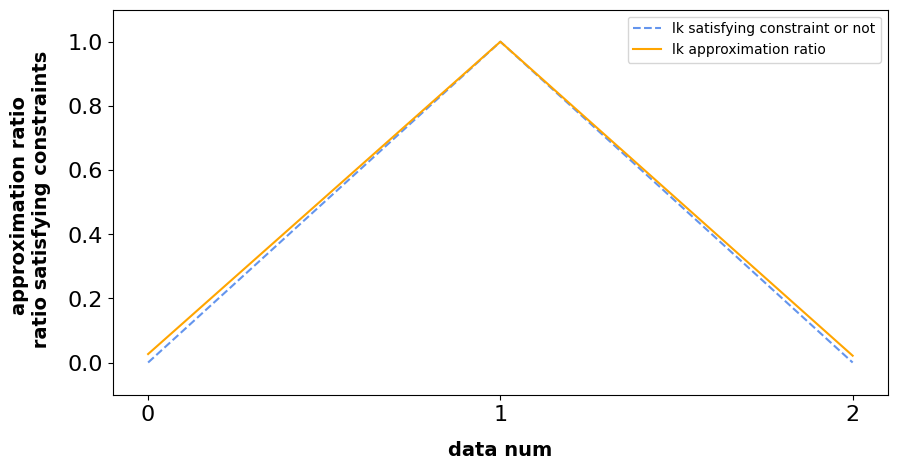

In [22]:
# Plotting results
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set x-axis
plt.xlabel('data num', fontsize=14, labelpad=12, fontweight='bold')
#plt.xscale('log')  # Setting x-axis to log scale
lk_inter_counts = np.ones(aa)
lk_inter_counts[np.array(lk_result) > 50000] = 0
print(lk_inter_counts[:3])
# Set y-axis1 data
ax1.set_ylabel('approximation ratio \n ratio satisfying constraints', fontsize=14, labelpad=12, fontweight='bold')
ax1.plot(rewiring_probs[:3], lk_inter_counts[:3], label='lk satisfying constraint or not', linestyle='--',
         color='cornflowerblue')
ax1.plot(rewiring_probs[:3], lk_success[:3], label='lk approximation ratio', color='orange')
ax1.set_ylim(-0.1, 1.1)
ax1.tick_params(labelsize=16)
ax1.set_xticks(range(aa)[:3], labels=rewiring_probs[:3])
plt.legend()
plt.show()

In [15]:
N = []
ave_degree = []
max_k = []
for j in range(len(distance_matrix)):
    mat = np.array(distance_matrix[j])
    mat[mat == 50000] = 0
    G = nx.Graph(mat)
    N.append(len(distance_matrix[j]))
    ave_degree.append(average_degree(G))
    max_k.append(max(dict(G.degree()).values()))

In [16]:
print(N)

[80, 14, 139, 25, 79, 70, 314, 171, 145, 172, 176, 168, 80, 65, 107]


In [17]:
file_name = f'TSP_dataframe_0412v1.json'
with open(file_name, 'r') as file:
    dataset0412 = json.load(file)
dd = dataset0412['dd']

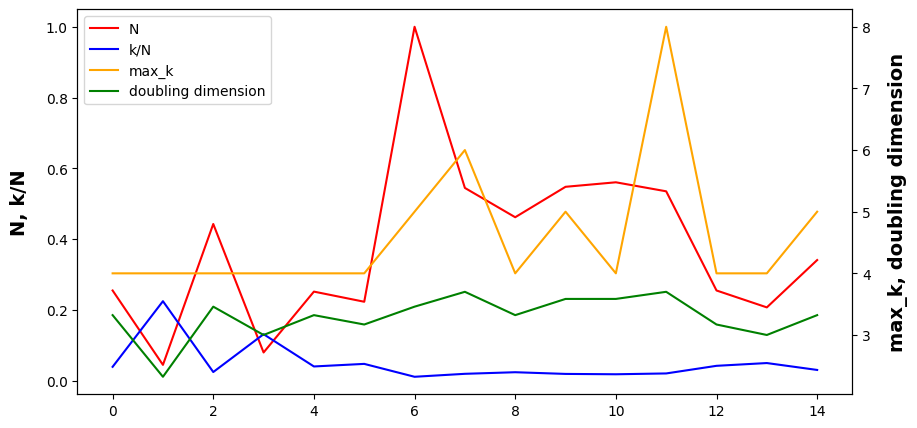

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.array(N)/max(N), color='red', label='N')
ax.plot(np.array(ave_degree)/N, color='blue', label='k/N')
ax3 = ax.twinx()
ax3.plot(max_k, color='orange', label='max_k')
ax3.plot(dd[:len(N)], color='green', label='doubling dimension')
ax.set_ylabel('N, k/N', fontsize=14, labelpad=12, fontweight='bold')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.set_ylabel('max_k, doubling dimension', fontsize=14, labelpad=12, fontweight='bold')
ax3.legend(lines + lines2, labels + labels2, loc='upper left')


In [23]:
print(max_k)

[4, 4, 4, 4, 4, 4, 5, 6, 4, 5, 4, 8, 4, 4, 5]


Graph with 80 nodes and 125 edges
[3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


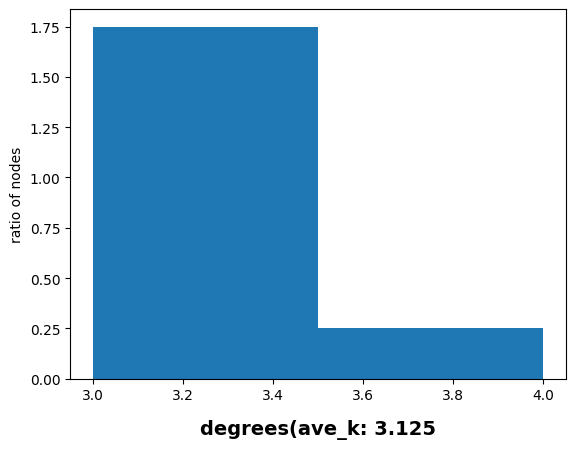

Graph with 14 nodes and 22 edges
[3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4]


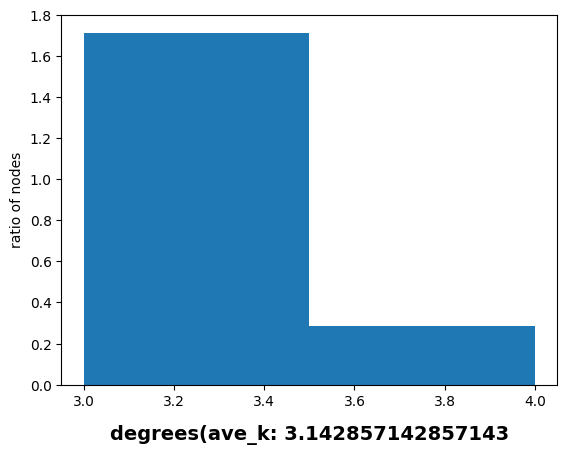

Graph with 139 nodes and 235 edges
[4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3]


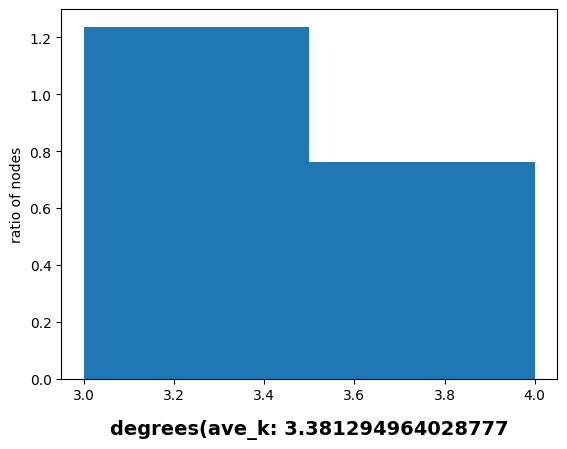

"mean_degree, std_degree = calculate_mean_and_std(degrees)\nmean_ave_degree = round(np.mean(ave_degree), 2)\nstd_ave_degree = round(np.std(ave_degree), 2)\n\n# plotting\nplt.figure(figsize=(7, 5))\n\nx_positions = np.arange(len(mean_degree))\nplt.bar(x_positions, mean_degree, yerr=std_degree, capsize=5, color='blue', alpha=0.7, align='center')\n\nlabels = x_positions\nplt.xticks(x_positions, labels)\n\n'''plt.title(f'degree distribution of k{average_k}, n{num_cities}, p{rewiring_probs[rew]} graph',\n          fontsize=16, fontweight='bold')'''\nplt.xlabel(f'degrees(mean ave_k: {mean_ave_degree}, std ave_k: {std_ave_degree})', fontsize=14, labelpad=12, fontweight='bold')\nplt.ylabel('ratio of edges', fontsize=14, labelpad=12, fontweight='bold')\nplt.ylim(0, 40)\n\nplt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.92)\nplt.show()"

In [26]:
degrees = []
aaa = len(distance_matrix)
for i in range(3):
    arr = np.array(distance_matrix[i])
    arr[arr == 50000] = 0
    G = nx.Graph(arr)
    print(G)
    degree_count = list(dict(G.degree()).values())
    print(degree_count)
    
    ave_degree = average_degree(G)
    plt.hist(degree_count, density=True, bins=len(set(degree_count)), align='mid')
    plt.xlabel(f'degrees(ave_k: {ave_degree}', fontsize=14, labelpad=12, fontweight='bold')
    plt.ylabel('ratio of nodes')
    plt.show()
"""mean_degree, std_degree = calculate_mean_and_std(degrees)
mean_ave_degree = round(np.mean(ave_degree), 2)
std_ave_degree = round(np.std(ave_degree), 2)

# plotting
plt.figure(figsize=(7, 5))

x_positions = np.arange(len(mean_degree))
plt.bar(x_positions, mean_degree, yerr=std_degree, capsize=5, color='blue', alpha=0.7, align='center')

labels = x_positions
plt.xticks(x_positions, labels)

'''plt.title(f'degree distribution of k{average_k}, n{num_cities}, p{rewiring_probs[rew]} graph',
          fontsize=16, fontweight='bold')'''
plt.xlabel(f'degrees(mean ave_k: {mean_ave_degree}, std ave_k: {std_ave_degree})', fontsize=14, labelpad=12, fontweight='bold')
plt.ylabel('ratio of edges', fontsize=14, labelpad=12, fontweight='bold')
plt.ylim(0, 40)

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.92)
plt.show()"""